In [52]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry

In [37]:
def iso2_to_iso3(iso2):
    try:
        if pd.notna(iso2):  # Verifica se il valore non è NaN
            iso2 = iso2.strip()  # Rimuove spazi bianchi
            return pycountry.countries.get(alpha_2=iso2).alpha_3
        return None
    except (AttributeError, LookupError):
        # Restituiamo None per codici non validi e stampiamo un avviso
        print(f"Codice ISO2 non valido: {iso2}")
        return None


In [2]:
input_dir = 'your/dir'
file_path_eu = os.path.join(input_dir, 'df_analisi_eu.csv')
file_path_us = os.path.join(input_dir, 'df_analisi_ofac.csv')

In [3]:
df_eu = pd.read_csv(file_path_eu, sep=';')
df_ofac = pd.read_csv(file_path_us, sep=';')

In [13]:
df_eu['sanctioned_type'] = df_eu['sanctioned_type'].str.replace('E', 'Entity')
df_eu['sanctioned_type'] = df_eu['sanctioned_type'].str.replace('P', 'Individual')

In [38]:
df_analysis['sanctioned_country_iso3'] = df_analysis['sanctioned_country_iso3'].fillna(
    df_analysis['sanctioned_country_iso2'].apply(iso2_to_iso3)
)

In [14]:
df_analysis = pd.concat([df_ofac, df_eu], ignore_index=True)
df_analysis = df_analysis.dropna(subset='sanctioned_id')
df_analysis = df_analysis.drop_duplicates()

,sanctioned_id,sanctioned_country_iso2,sanctioned_type,sanction_listing_date,sanction_text,sanction_body,sanctioned_country_iso3
0,36.0,CU,Entity,1986-12-10,Unknown,OFAC,NaN
1,173.0,GB,Entity,1984-07-12,Unknown,OFAC,NaN
2,306.0,CH,Entity,1989-03-30,Executive Order 12854 (Cuba),OFAC,NaN
3,306.0,ES,Entity,1989-03-30,Executive Order 12854 (Cuba),OFAC,NaN
4,306.0,JP,Entity,1989-03-30,Executive Order 12854 (Cuba),OFAC,NaN
...,...,...,...,...,...,...,...
67516,172434.0,NaN,Individual,2025-01-10,VEN - 2025/44 (OJ L10012025),EU,NaN
67519,172440.0,NaN,Individual,2025-01-10,VEN - 2025/44 (OJ L10012025),EU,NaN
67522,172446.0,NaN,Individual,2025-01-10,VEN - 2025/44 (OJ L10012025),EU,NaN
67525,172452.0,NaN,Individual,2025-01-10,VEN - 2025/44 (OJ L10012025),EU,NaN


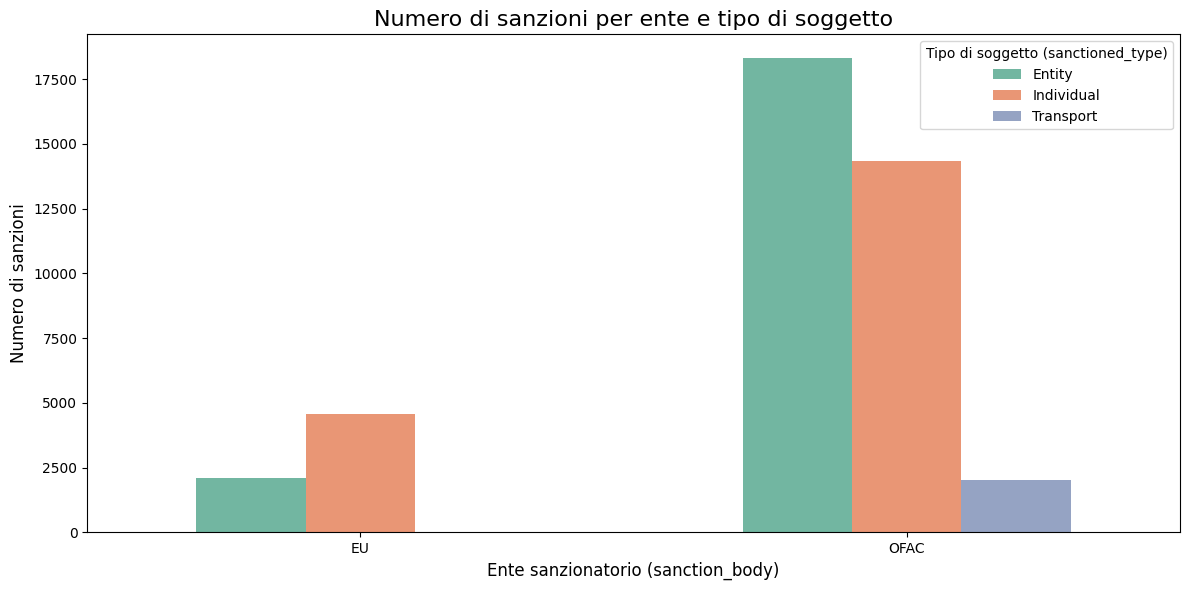

In [18]:
# Aggregare i dati
df_grouped = df_analysis.groupby(['sanction_body', 'sanctioned_type']).size().reset_index(name='num_sanctions')

# Creare il bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_grouped, 
    x='sanction_body', 
    y='num_sanctions', 
    hue='sanctioned_type', 
    palette='Set2',
    dodge=True,  # Mantiene il raggruppamento
    width=0.6    # Regola la larghezza delle barre
)

# Personalizzazione del grafico
plt.title("Numero di sanzioni per ente e tipo di soggetto", fontsize=16)
plt.xlabel("Ente sanzionatorio (sanction_body)", fontsize=12)
plt.ylabel("Numero di sanzioni", fontsize=12)
plt.legend(title="Tipo di soggetto (sanctioned_type)")
plt.tight_layout()

# Mostrare il grafico
plt.show()

C:\Users\valer\AppData\Local\Temp\ipykernel_10364\512369240.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot_data = pd.DataFrame(index=all_years, columns=all_bodies).fillna(0)


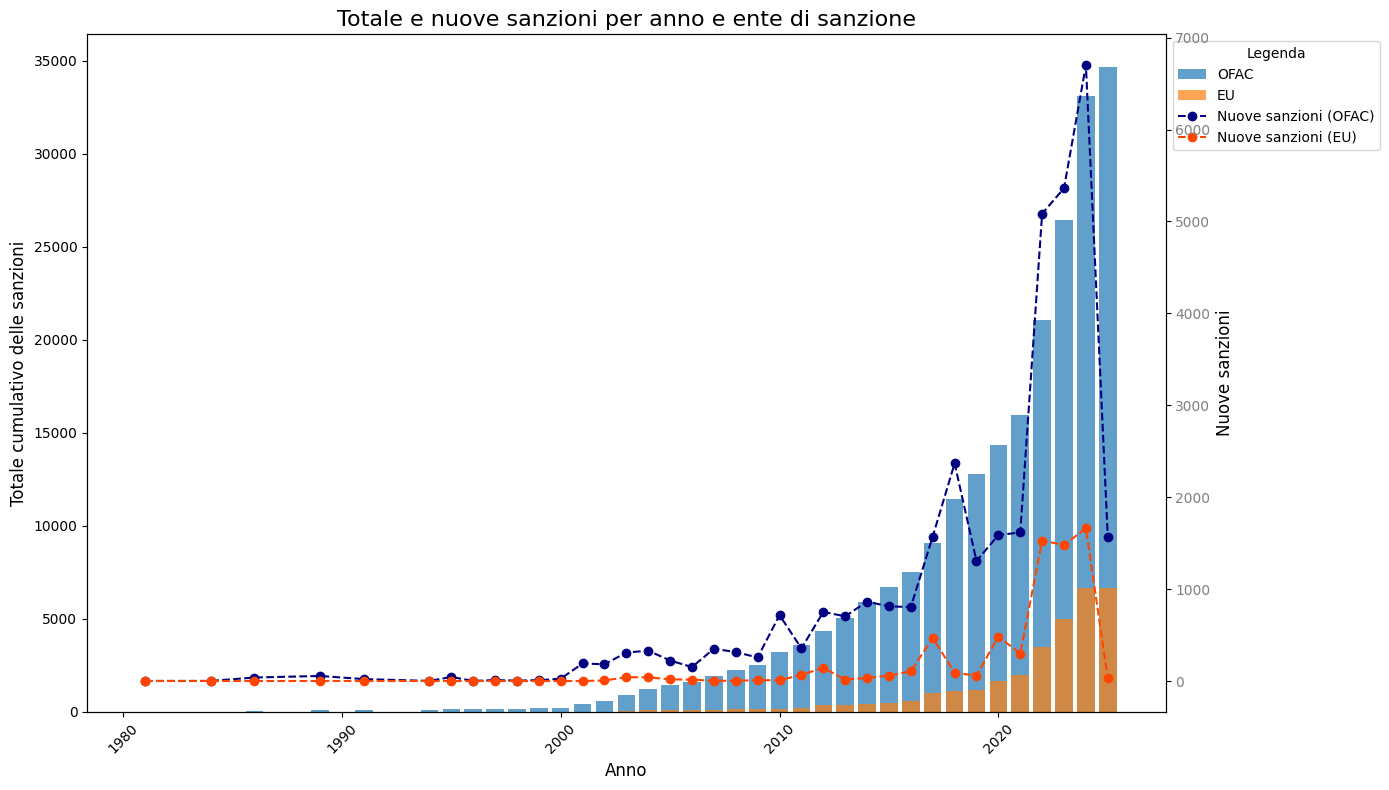

In [30]:
# Convertire la colonna delle date in formato datetime
df_analysis['sanction_listing_date'] = pd.to_datetime(df_analysis['sanction_listing_date'])

# Estrarre l'anno dalla colonna delle date
df_analysis['sanction_year'] = df_analysis['sanction_listing_date'].dt.year

df_new = df_analysis.groupby(['sanction_year', 'sanction_body']).size().reset_index(name='new_sanctions')

# Tabella pivot
all_years = sorted(df_analysis['sanction_year'].unique())
all_bodies = df_analysis['sanction_body'].unique()
pivot_data = pd.DataFrame(index=all_years, columns=all_bodies).fillna(0)

for index, row in df_new.iterrows():
    pivot_data.at[row['sanction_year'], row['sanction_body']] = row['new_sanctions']

pivot_data = pivot_data.fillna(0)

# cumulativo per ogni ente
cumulative_data = pivot_data.cumsum()

# Colori personalizzati per ogni ente
custom_colors_bar = {
    "OFAC": "tab:blue",  # Blu
    "EU": "tab:orange",  # Arancione
}

fig, ax1 = plt.subplots(figsize=(14, 8))

# 1. Barre per il totale cumulato delle sanzioni (asse y)
for body in cumulative_data.columns:
    ax1.bar(
        cumulative_data.index, 
        cumulative_data[body], 
        label=body, 
        alpha=0.7, 
        color=custom_colors_bar.get(body, "#7f7f7f")  # Usa il colore personalizzato o grigio come fallback
    )

ax1.set_ylabel("Totale cumulativo delle sanzioni", fontsize=12)
ax1.set_xlabel("Anno", fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.set_title("Totale e nuove sanzioni per anno e ente di sanzione", fontsize=16)

# 2. Linee "trend" per le nuove sanzioni in ogni anno (asse y a destra)
ax2 = ax1.twinx()  # Asse secondario

custom_colors_trend = {
    "OFAC": "navy", 
    "EU": "orangered",
}

for body in pivot_data.columns:
    ax2.plot(
        pivot_data.index, 
        pivot_data[body], 
        marker='o', 
        linestyle='--', 
        color=custom_colors_trend.get(body, "#7f7f7f"),  # stesso colore delle barre
        label=f"Nuove sanzioni ({body})"
    )

ax2.set_ylabel("Nuove sanzioni", fontsize=12)
ax2.tick_params(axis='y', labelcolor='gray')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='upper left', bbox_to_anchor=(1, 1), title="Legenda")

plt.tight_layout()
plt.show()

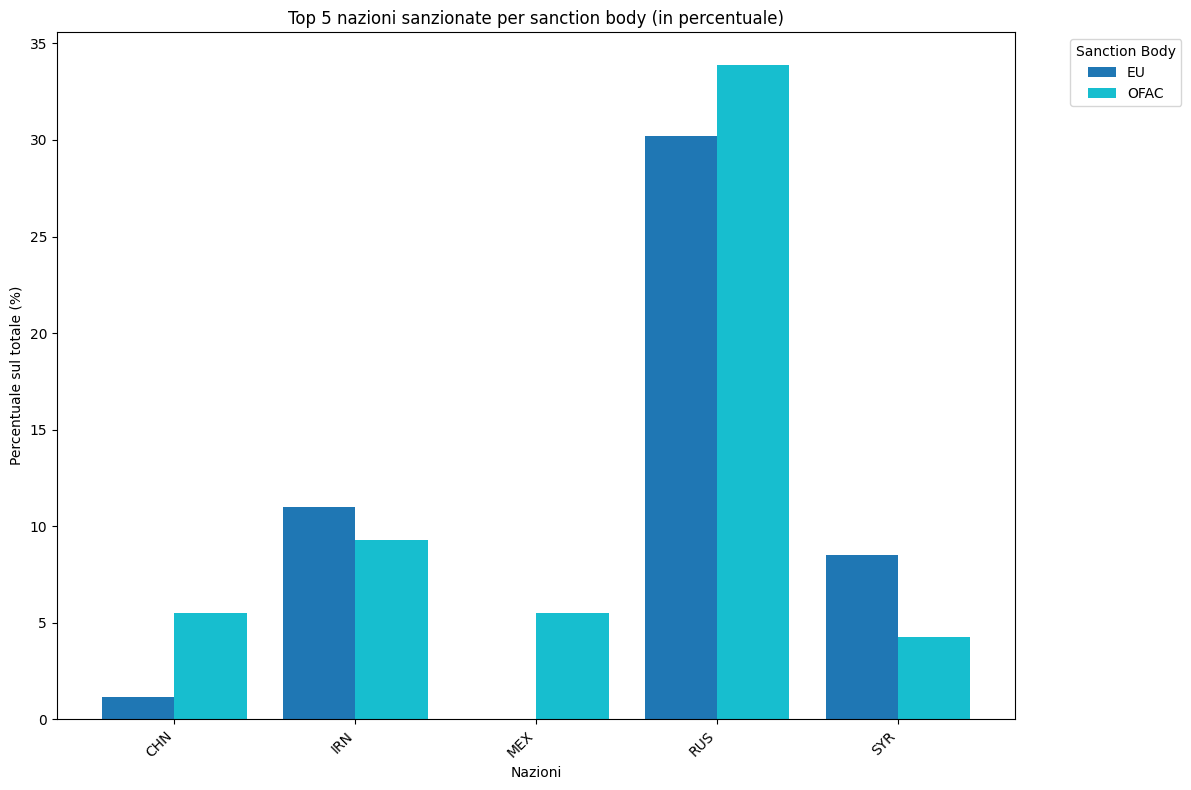

In [46]:
# Calcolo del totale dei soggetti sanzionati per ogni combinazione
total_by_country = (
    df_analysis.groupby(['sanction_body', 'sanctioned_country_iso3'])
    .size()
    .reset_index(name='total_sanctions')
)

# Calcolo del totale per ogni ente
total_by_body = total_by_country.groupby('sanction_body')['total_sanctions'].sum().reset_index(name='total_body_sanctions')

# Merge per le percentuali
total_by_country = total_by_country.merge(total_by_body, on='sanction_body')
total_by_country['percentage'] = (total_by_country['total_sanctions'] / total_by_country['total_body_sanctions']) * 100

# Selezione delle top 5 nazioni sanzionate 
top_countries = (
    total_by_country.groupby('sanctioned_country_iso3')['total_sanctions']
    .sum()
    .nlargest(5)
    .index
)

# solo le top 5 nazioni
top_5_countries = total_by_country[total_by_country['sanctioned_country_iso3'].isin(top_countries)]

# Pivot per creare un formato adatto al grafico
pivot_data = top_5_countries.pivot_table(
    index='sanctioned_country_iso3',
    columns='sanction_body',
    values='percentage',
    fill_value=0
)

# Creazione del grafico
pivot_data.plot(
    kind='bar',
    figsize=(12, 8),
    width=0.8,
    colormap='tab10' 
)

plt.ylabel('Percentuale sul totale (%)')
plt.xlabel('Nazioni')
plt.title('Top 5 nazioni sanzionate per sanction body (in percentuale)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sanction Body', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()